In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-sales-data/sales_data_sample.csv


# **Import Libraries**

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


import warnings
warnings.filterwarnings('ignore')

In [107]:
df = pd.read_csv('/kaggle/input/sample-sales-data/sales_data_sample.csv',encoding='latin1')
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [108]:
def wrangle(path):
    df = pd.read_csv(path,encoding='latin1')
    df.dropna(axis=1,inplace=True)
    df = df[['QUANTITYORDERED','PRICEEACH','ORDERLINENUMBER', 'SALES', 'ORDERDATE', 'PRODUCTLINE', 'MSRP','COUNTRY','DEALSIZE']]
    df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

    df['sale_year'] = df['ORDERDATE'].dt.year
    df['sale_month'] = df['ORDERDATE'].dt.month
    df['sale_day'] = df['ORDERDATE'].dt.day
    
    df.drop('ORDERDATE',axis=1,inplace=True)
    return df


# **Basic Analysis**

In [109]:
#basic analysis
print('Information of the data\n\n', df.info())
print('Columns of the data\n\n', df.columns)
print('Null values\n', df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


> **Since we have to do sales forecasting. We will use only those columns that may help to fulfil our purpose.**

In [110]:
df.dropna(axis=1,inplace=True)

In [111]:
#take only useful columns

df_saling_record = df[['QUANTITYORDERED','PRICEEACH','ORDERLINENUMBER', 'SALES', 'ORDERDATE', 'PRODUCTLINE', 'MSRP','COUNTRY','DEALSIZE']]
df_saling_record.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,PRODUCTLINE,MSRP,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2/24/2003 0:00,Motorcycles,95,USA,Small
1,34,81.35,5,2765.90,5/7/2003 0:00,Motorcycles,95,France,Small
2,41,94.74,2,3884.34,7/1/2003 0:00,Motorcycles,95,France,Medium
3,45,83.26,6,3746.70,8/25/2003 0:00,Motorcycles,95,USA,Medium
4,49,100.00,14,5205.27,10/10/2003 0:00,Motorcycles,95,USA,Medium


In [112]:
#available saled products

df_saling_record['PRODUCTLINE'].value_counts()

PRODUCTLINE
Classic Cars        967
Vintage Cars        607
Motorcycles         331
Planes              306
Trucks and Buses    301
Ships               234
Trains               77
Name: count, dtype: int64

# **Datetime conversion**

In [113]:
df_saling_record['ORDERDATE'] = pd.to_datetime(df_saling_record['ORDERDATE'])

In [114]:
df_saling_record.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,PRODUCTLINE,MSRP,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Motorcycles,95,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Motorcycles,95,France,Small
2,41,94.74,2,3884.34,2003-07-01,Motorcycles,95,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Motorcycles,95,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Motorcycles,95,USA,Medium


# **SALES DISTRIBUTION PRODUCT WISE**

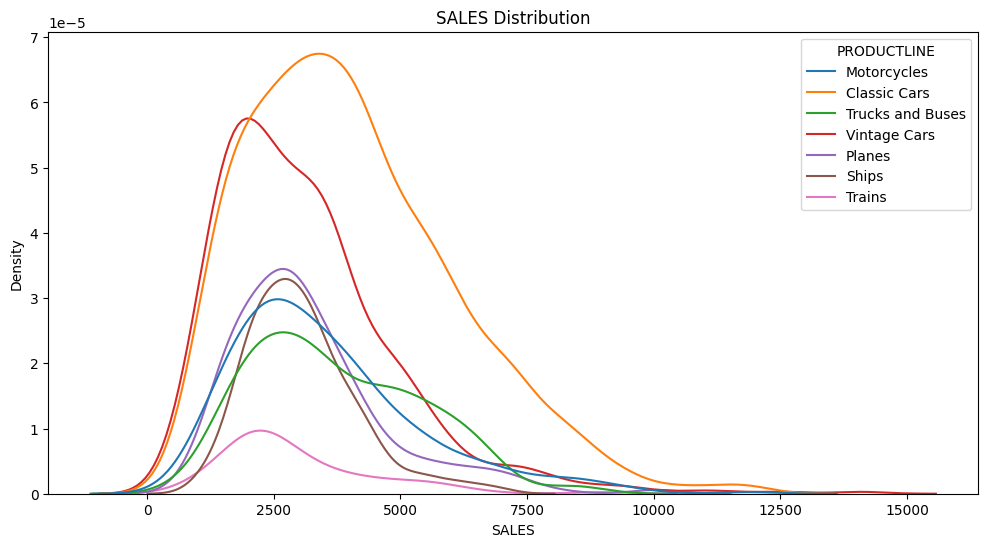

In [115]:
plt.figure(figsize=(12,6))
sns.kdeplot(data= df_saling_record, x='SALES',hue='PRODUCTLINE')
plt.title('SALES Distribution')
plt.show()

>  **All the sales are between 0 and 10000. Some sales lines are above 10000. The KDE is right-skewed.** 

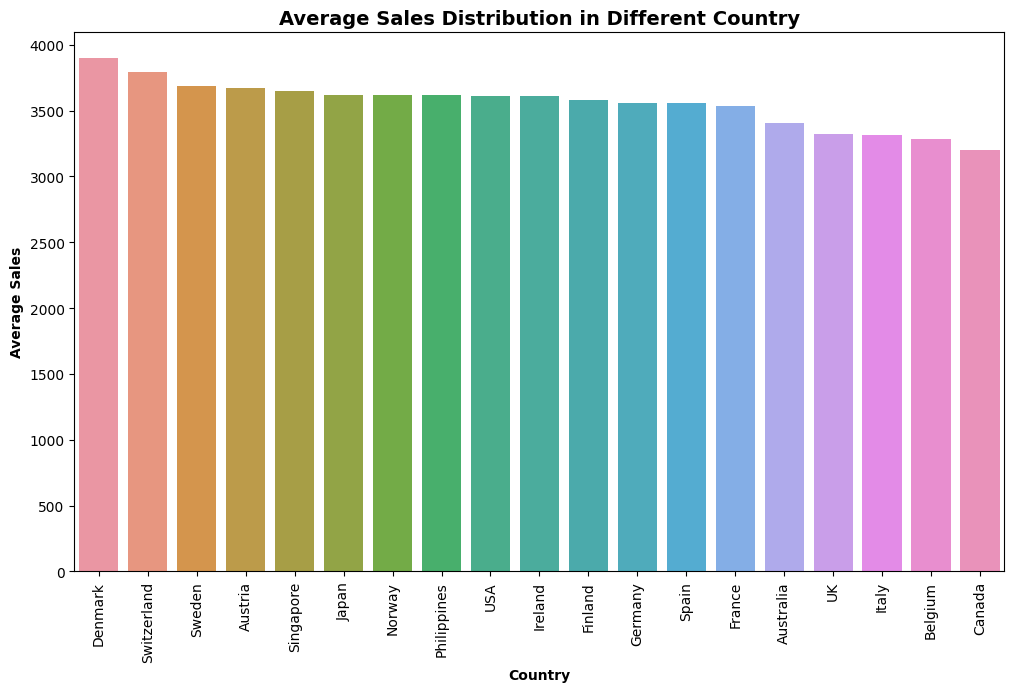

In [116]:
country_wise_sale = df_saling_record.groupby(['COUNTRY'])['SALES'].mean().sort_values(ascending=False).round(3)

plt.figure(figsize=(12,7))
sns.barplot(x=country_wise_sale.index,y=country_wise_sale.values)
plt.xticks(rotation=90)
plt.title('Average Sales Distribution in Different Country',weight='bold',fontsize=14)
plt.xlabel('Country',weight='bold')
plt.ylabel('Average Sales',weight='bold')
plt.show()

# **Extract time-based features**

In [117]:
df_saling_record['sale_year'] = df_saling_record['ORDERDATE'].dt.year
df_saling_record['sale_month'] = df_saling_record['ORDERDATE'].dt.month
df_saling_record['sale_day'] = df_saling_record['ORDERDATE'].dt.day
df_saling_record.head()

# **Yearly, Monthly, Daily Sales Distribution**

In [118]:
# Yearly Sales
yearly_sales = df_saling_record.groupby(df_saling_record['sale_year'])['SALES'].mean().reset_index()
yearly_sales.columns = ['YEAR', 'AVG_SALES']

# Monthly Sales
monthly_sales = df_saling_record.groupby(df_saling_record['sale_month'])['SALES'].mean().reset_index()
monthly_sales.columns = ['MONTH', 'AVG_SALES']

# Daily Sales
daily_sales = df_saling_record.groupby(df_saling_record['sale_day'])['SALES'].mean().reset_index()
daily_sales.columns = ['DATE', 'AVG_SALES']

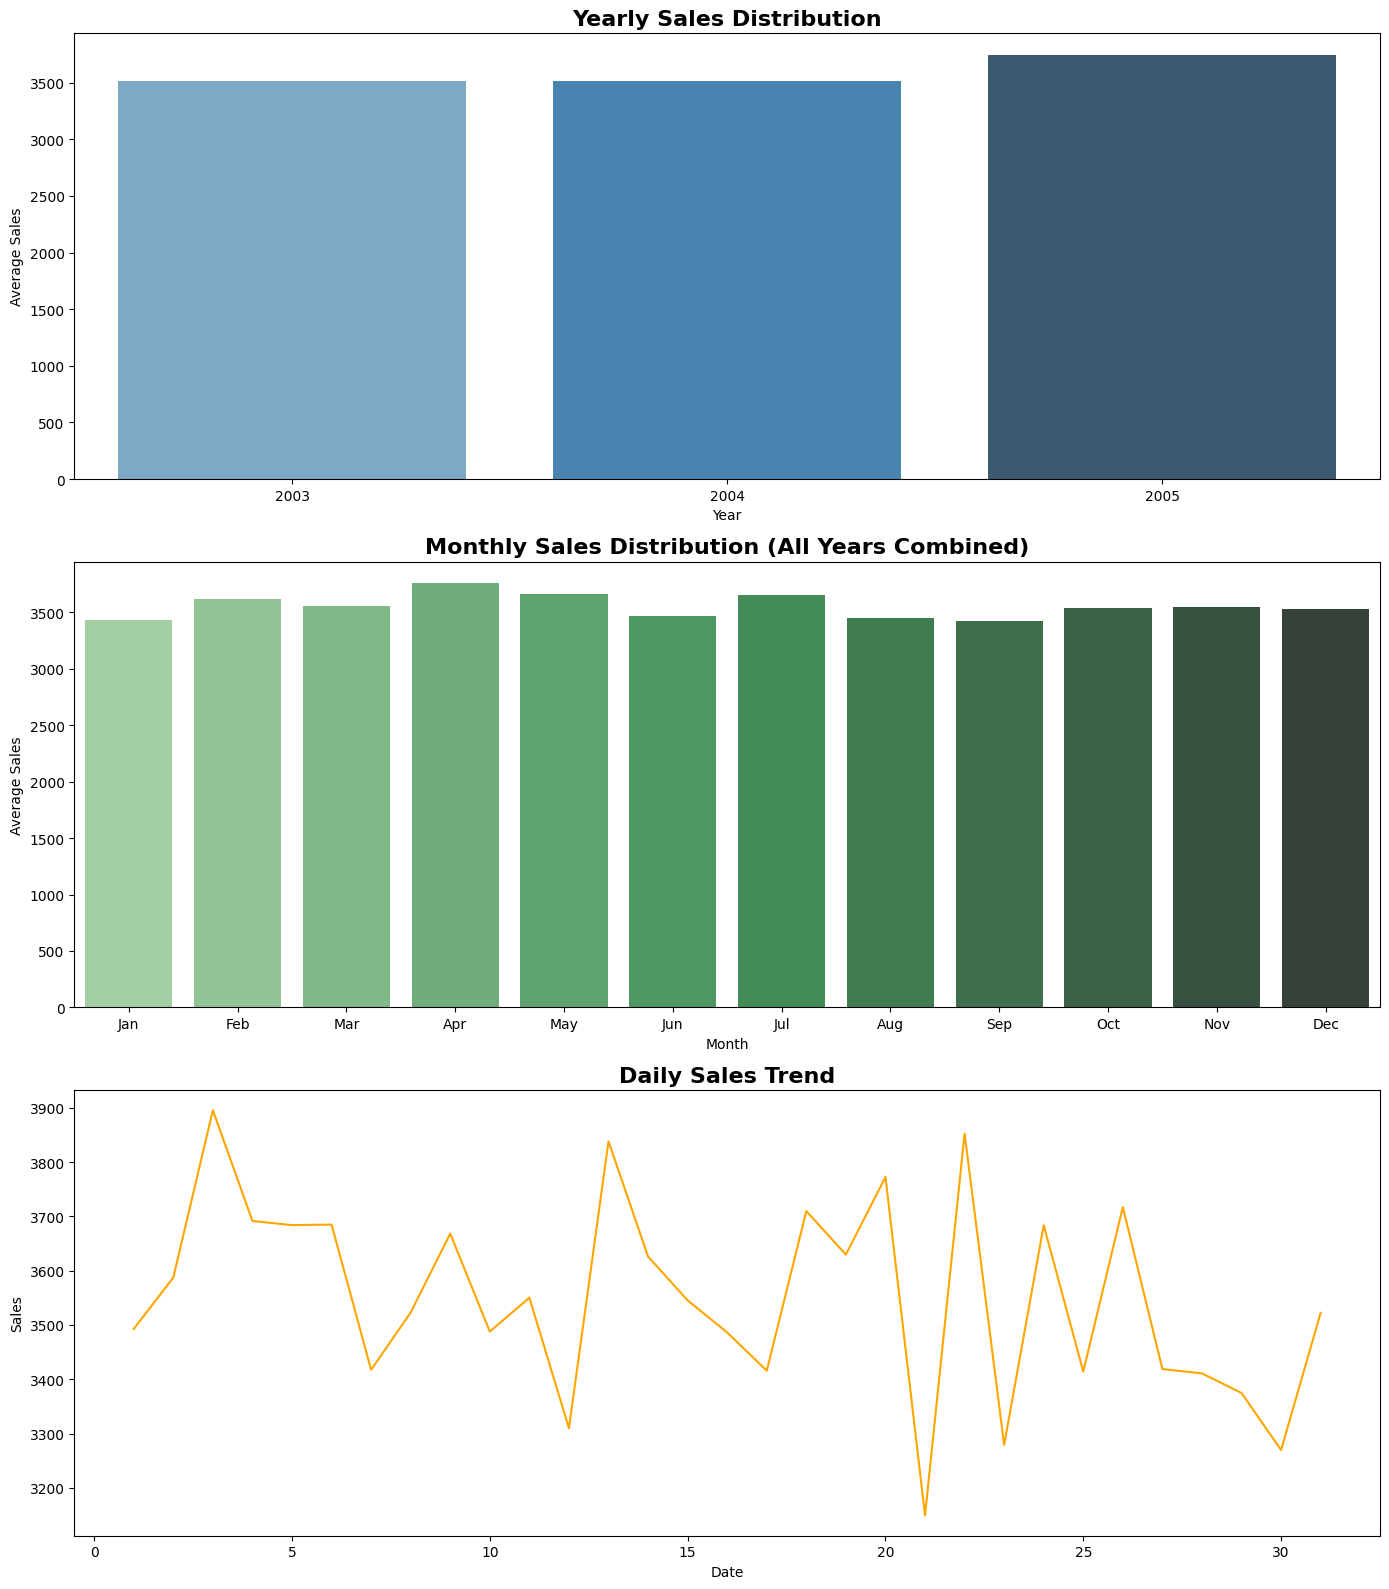

In [119]:
# Set up dashboard layout
fig, axes = plt.subplots(3, 1, figsize=(14, 16), tight_layout=True)

# Yearly Sales Plot
sns.barplot(ax=axes[0], data=yearly_sales, x='YEAR', y='AVG_SALES', palette='Blues_d')
axes[0].set_title('Yearly Sales Distribution', fontsize=16, weight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Sales')

# Monthly Sales Plot
sns.barplot(ax=axes[1], data=monthly_sales, x='MONTH', y='AVG_SALES', palette='Greens_d')
axes[1].set_title('Monthly Sales Distribution (All Years Combined)', fontsize=16, weight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Sales')
axes[1].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Daily Sales Plot
sns.lineplot(ax=axes[2], data=daily_sales, x='DATE', y='AVG_SALES', color='orange')
axes[2].set_title('Daily Sales Trend', fontsize=16,weight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Sales')

plt.show()

# **Yearly Sales Forecasting**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


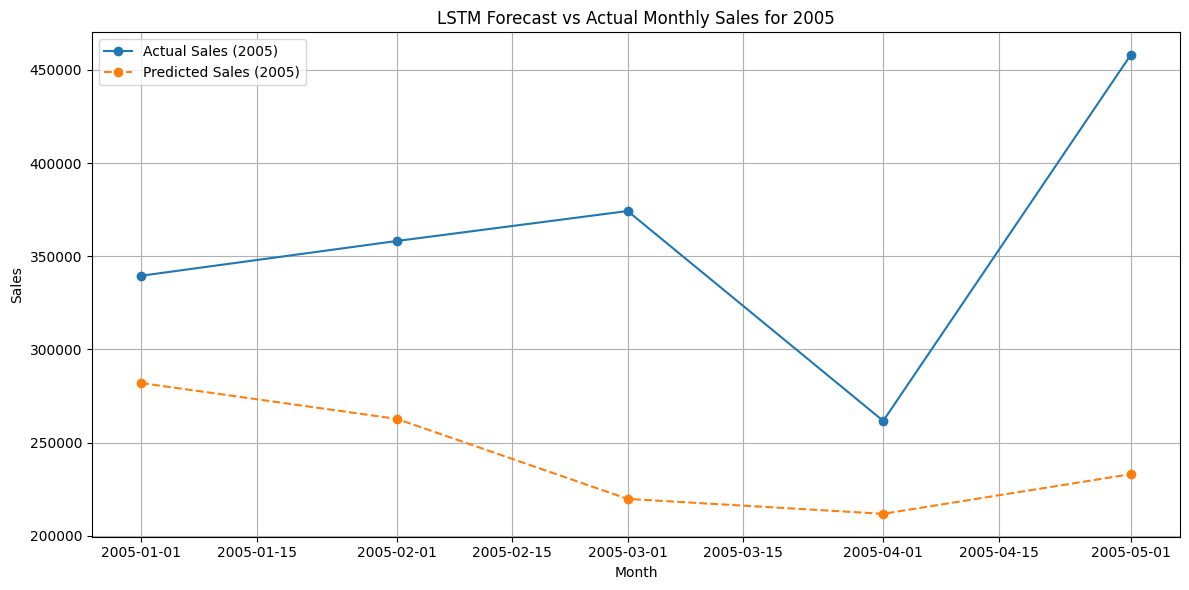

In [129]:
# Extract YearMonth
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE']) 
df['YearMonth'] = df['ORDERDATE'].dt.to_period('M').astype(str)

# Aggregate monthly sales
monthly_sales = df.groupby('YearMonth')['SALES'].sum().reset_index()
monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales['YearMonth'])

# Sort the data
monthly_sales = monthly_sales.sort_values('YearMonth').reset_index(drop=True)

# Scale sales
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(monthly_sales[['SALES']])

# Create LSTM sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(sales_scaled, seq_length)

# Split: train = 2003–2004, test = 2005
split_index = monthly_sales[monthly_sales['YearMonth'].dt.year == 2005].index.min() - seq_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=1000, verbose=0)

# Predict on test
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# Prepare results for plotting
predicted_dates = monthly_sales['YearMonth'][seq_length + split_index:seq_length + split_index + len(y_pred)]
forecast_df = pd.DataFrame({
    'Date': predicted_dates,
    'Actual': y_actual.flatten(),
    'Predicted': y_pred.flatten()
})

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Actual'], marker='o', label='Actual Sales (2005)')
plt.plot(forecast_df['Date'], forecast_df['Predicted'], marker='o', linestyle='--', label='Predicted Sales (2005)')
plt.title('LSTM Forecast vs Actual Monthly Sales for 2005')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **Daily Sales Forecasting**

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Prepare Data (make sure 'ORDERDATE' is datetime and 'SALES' exists)
df_saling_record['ORDERDATE'] = pd.to_datetime(df_saling_record['ORDERDATE'])

# 2. Aggregate daily sales
daily_sales = df_saling_record.groupby('ORDERDATE')['SALES'].sum().reset_index()
daily_sales = daily_sales.sort_values('ORDERDATE')

# 3. Normalize sales values
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(daily_sales[['SALES']])

# 4. Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # use past 30 days to predict the next
X, y = create_sequences(sales_scaled, seq_length)

# 5. Train/test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# 6. Build and train LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1192
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0829 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0462 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0395 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0407 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0406 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0345 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0382 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0402 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0347
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0378
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0359
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0363 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0367 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0416
Epoch 16/100
6/6 ━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


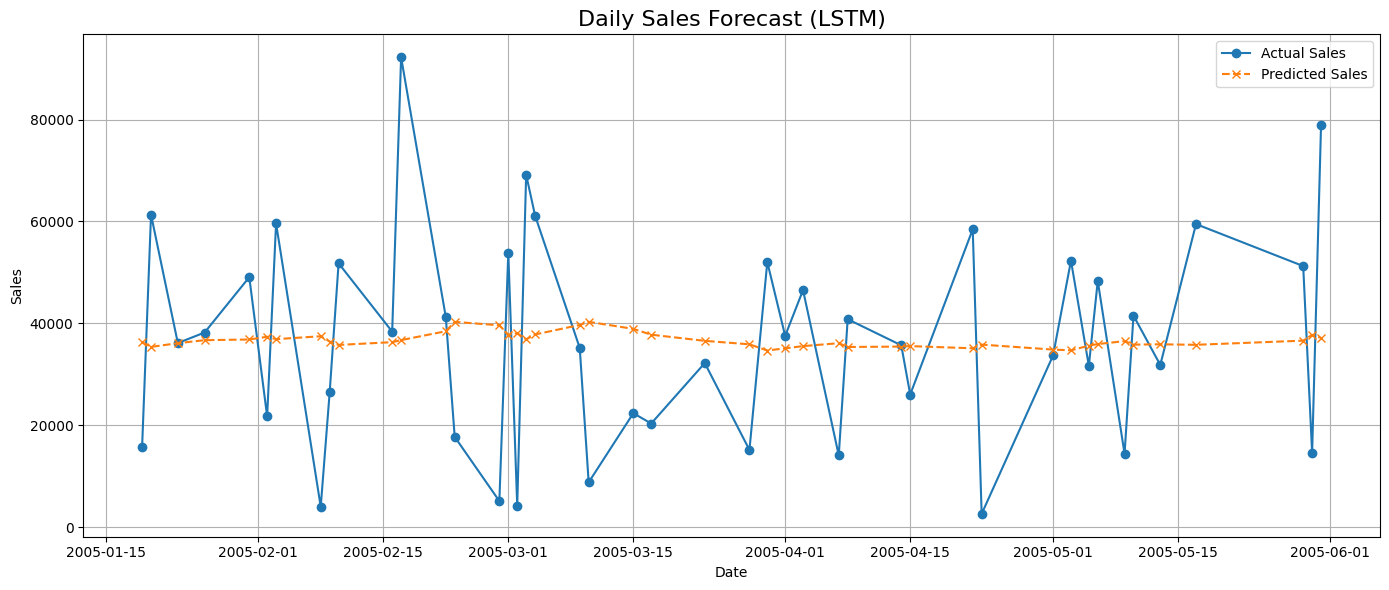

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Forecasted sales for the next day: 38261.58


In [143]:
# 7. Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# 8. Prepare DataFrame for plotting
predict_dates = daily_sales['ORDERDATE'][seq_length + split:seq_length + split + len(y_pred)]
forecast_df = pd.DataFrame({
    'Date': predict_dates,
    'Actual': y_actual.flatten(),
    'Predicted': y_pred.flatten()
})

# 9. Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(forecast_df['Date'], forecast_df['Actual'], label='Actual Sales', marker='o')
plt.plot(forecast_df['Date'], forecast_df['Predicted'], label='Predicted Sales', marker='x', linestyle='--')
plt.title('Daily Sales Forecast (LSTM)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Forecast next day sales
last_seq = sales_scaled[-seq_length:]
last_seq = last_seq.reshape((1, seq_length, 1))
next_day_scaled = model.predict(last_seq)
next_day_sales = scaler.inverse_transform(next_day_scaled)
print("Forecasted sales for the next day:", round(next_day_sales[0][0], 2))

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2578 - val_loss: 0.0284
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0472 - val_loss: 0.0277
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0410 - val_loss: 0.0322
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0397 - val_loss: 0.0296
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0351 - val_loss: 0.0274
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0425 - val_loss: 0.0278
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0300 - val_loss: 0.0285
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0351 - val_loss: 0.0276
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0256 - val_loss: 0.0274
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0305 - val_loss: 0.0289
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0357 - val_loss: 0.0273
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0363 - val_loss: 0.0288
Epoch 13/30


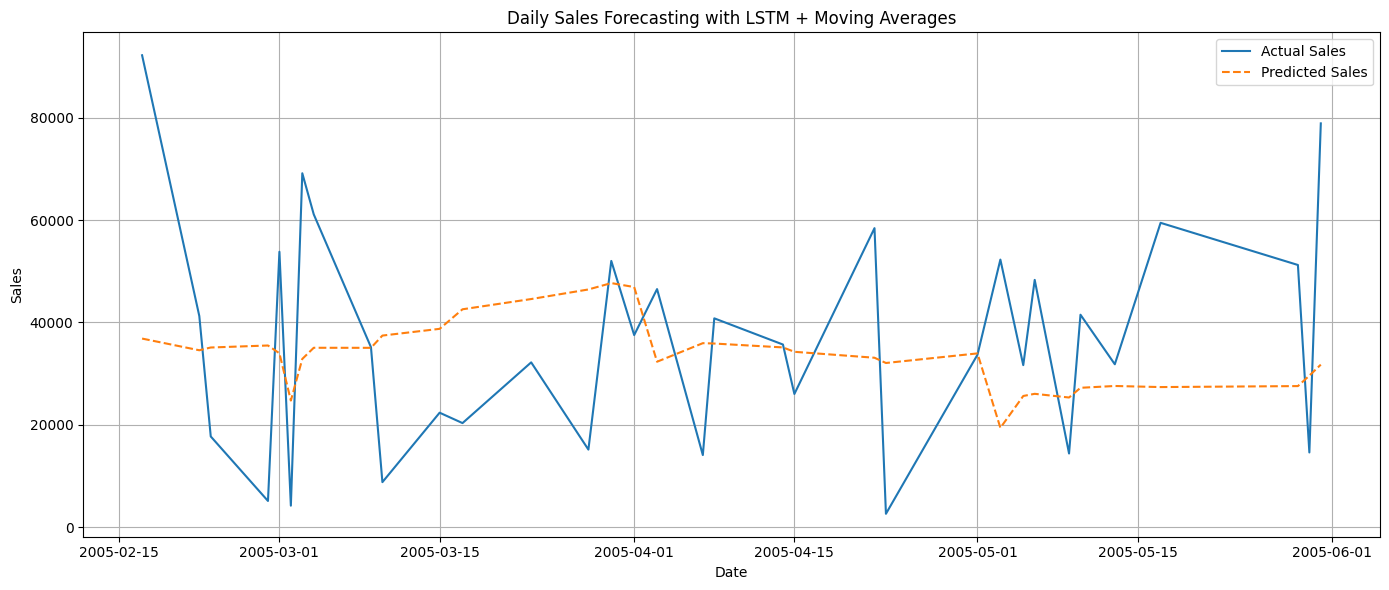

MSE: 537120554.86
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Forecasted sales for next day: 28278.73


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Assume df has 'ORDERDATE' as index and 'SALES' as column
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['month'] = df.index.month
df['day'] = df.index.day

# Lag features
df['lag_1'] = df['SALES'].shift(1)
df['lag_7_mean'] = df['SALES'].shift(1).rolling(window=7).mean()

# Rolling stats
df['MA_3'] = df['SALES'].rolling(window=3).mean()
df['MA_7'] = df['SALES'].rolling(window=7).mean()
df['MA_14'] = df['SALES'].rolling(window=14).mean()
df['STD_3'] = df['SALES'].rolling(window=3).std()
df['STD_7'] = df['SALES'].rolling(window=7).std()
df['STD_14'] = df['SALES'].rolling(window=14).std()
df['rolling_max'] = df['SALES'].rolling(window=7).max()
df['rolling_min'] = df['SALES'].rolling(window=7).min()

# Sales trend/diff
df['diff_1'] = df['SALES'].diff()

# Drop initial NaNs caused by rolling/lags
df = df.dropna()


# 3. Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 4. Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i, 0])  # Target is original SALES
    return np.array(X), np.array(y)

sequence_length = 14  # 14 days lookback
X, y = create_sequences(scaled_data, sequence_length)

# 5. Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. Build LSTM Model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 7. Train Model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

# 8. Predict and Inverse Transform
predicted = model.predict(X_test)
true_scaled = np.zeros((len(y_test), scaled_data.shape[1]))
true_scaled[:, 0] = y_test
pred_scaled = np.zeros((len(predicted), scaled_data.shape[1]))
pred_scaled[:, 0] = predicted.flatten()

true_sales = scaler.inverse_transform(true_scaled)[:, 0]
pred_sales = scaler.inverse_transform(pred_scaled)[:, 0]

# 9. Plot Results
plt.figure(figsize=(14, 6))
plt.plot(df.index[-len(true_sales):], true_sales, label='Actual Sales')
plt.plot(df.index[-len(pred_sales):], pred_sales, label='Predicted Sales', linestyle='--')
plt.title("Daily Sales Forecasting with LSTM + Moving Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Evaluation
rmse = mean_squared_error(true_sales, pred_sales)
print("MSE:", round(rmse, 2))

# 11. Forecast next day
last_sequence = scaled_data[-sequence_length:]
last_sequence = np.expand_dims(last_sequence, axis=0)
next_scaled_pred = model.predict(last_sequence)
next_pred_array = np.zeros((1, scaled_data.shape[1]))
next_pred_array[0, 0] = next_scaled_pred
next_sales = scaler.inverse_transform(next_pred_array)[0, 0]
print("Forecasted sales for next day:", round(next_sales, 2))
